In [1]:
!pip install -q datasets
!pip install transformers

You should consider upgrading via the 'C:\Users\ROG\Downloads\FP_DL\venv\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\ROG\Downloads\FP_DL\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from google.colab import drive
import pandas as pd
import numpy as np
import os
import glob
import tensorflow as tf
from tensorflow import keras


c:\Users\ROG\Downloads\FP_DL\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# drive.mount('/content/drive')

"""save dataset to variable"""
#ds = load_dataset("./drive/MyDrive/FP_DL/daily_dialog.py","ds")
ds = load_dataset("./daily_dialog.py","ds")

Found cached dataset daily_dialog (C:/Users/ROG/.cache/huggingface/datasets/daily_dialog/ds/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
100%|██████████| 3/3 [00:00<00:00, 28.84it/s]


# **Explorasi Data**

###### melihat karakteristik data dan melihat distribusi data

#### *Buat label_map untuk data pada emotion dan action*

In [4]:
label_emo = { no:str(label) for no, label in enumerate(ds['train'].features['emotion'].feature.names)}

In [5]:
label_emo[0] = 'noemotion'

In [6]:
label_emo

{0: 'noemotion',
 1: 'anger',
 2: 'disgust',
 3: 'fear',
 4: 'happiness',
 5: 'sadness',
 6: 'surprise'}

In [7]:
label_act = { no:str(label) for no, label in enumerate(ds['train'].features['act'].feature.names)}

In [8]:
label_act[0] = 'dummy'

In [9]:
label_act

{0: 'dummy', 1: 'inform', 2: 'question', 3: 'directive', 4: 'commissive'}

In [10]:
ds

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})

In [11]:
def decompose_data(ds,key):
  result = {}

  result['dialog'] = ds[key]['dialog']
  result['emotion'] = ds[key]['emotion']
  result['act'] = ds[key]['act']
  result['dialog_arr'] = []
  result['actions_arr'] = []
  result['emotions_arr'] = []

  for i in result['dialog'][:]:
      for conv in i:
          text = conv.rsplit("\"",1)
          result['dialog_arr'].append(text[0])

  for i in result['act'][:]:
    converted = list(i)
    for action in converted:
        result['actions_arr'].append(action)

  for i in result['emotion'][:]:
    converted = list(i)
    for emotion in converted:
        result['emotions_arr'].append(emotion)


  return result




In [12]:
train = decompose_data(ds,'train')
train_data = [ train['dialog_arr'], train['actions_arr'], train['emotions_arr'] ]

train_data = list(zip(*train_data))

df_train = pd.DataFrame(train_data,columns=['texts','actions','emotions'])
df_train['actions'].replace(label_act, inplace=True)
df_train['emotions'].replace(label_emo, inplace=True)
df_train["category"] = df_train[['actions', 'emotions']].agg({lambda x: x.tolist()}, axis=1)
df_train

texts     actions   
0      Say , Jim , how about going for a few beers af...   directive  \
1       You know that is tempting but is really not g...  commissive   
2         What do you mean ? It will help us to relax .     question   
3       Do you really think so ? I don't . It will ju...    question   
4       I guess you are right.But what shall we do ? ...    question   
...                                                  ...         ...   
87165                          I want a pair of locus .    directive   
87166     Take a look at the ones on display , please .   commissive   
87167                                  I need size 41 .    directive   
87168                 Could I have the check , please ?    directive   
87169                    Okay . I'll just be a minute .   commissive   

        emotions                 category  
0      noemotion   [directive, noemotion]  
1      noemotion  [commissive, noemotion]  
2      noemotion    [question, noemotion]  
3      noemotion    [question, noemotion]  
4      noemotion    [question, noemotion]  
...          ...                      ...  
87165  noemotion   [directive, noemotion]  
87166  noemotion  [commissive, noemotion]  
87167  noemotion   [directive, noemotion]  
87168  noemotion   [directive, noemotion]  
87169  noemotion  [commissive, noemotion]  

[87170 rows x 4 columns]

In [13]:
test = decompose_data(ds,'test')
test_data = [ test['dialog_arr'], test['actions_arr'], test['emotions_arr'] ]

test_data = list(zip(*test_data))

df_test = pd.DataFrame(test_data,columns=['texts','actions','emotions'])
df_test['actions'].replace(label_act, inplace=True)
df_test['emotions'].replace(label_emo, inplace=True)
df_test["category"] = df_test[['actions', 'emotions']].agg({lambda x: x.tolist()}, axis=1)
df_test

texts     actions   
0                  Hey man , you wanna buy some weed ?    directive  \
1                                          Some what ?     question   
2      Weed ! You know ? Pot , Ganja , Mary Jane som...   directive   
3                               Oh , umm , no thanks .   commissive   
4      I also have blow if you prefer to do a few li...   directive   
...                                                 ...         ...   
7735   are you kidding ? Can you afford it ? Do you ...    question   
7736   never mind that , I'll take care of it . Are ...   directive   
7737                               yeah , I think so .   commissive   
7738   ok . I'll make the arrangements . It will be ...      inform   
7739    wonderful ! I'll start packing our suitcases .       inform   

       emotions                 category  
0     noemotion   [directive, noemotion]  
1      surprise     [question, surprise]  
2     noemotion   [directive, noemotion]  
3     noemotion  [commissive, noemotion]  
4     noemotion   [directive, noemotion]  
...         ...                      ...  
7735   surprise     [question, surprise]  
7736  noemotion   [directive, noemotion]  
7737  noemotion  [commissive, noemotion]  
7738  happiness      [inform, happiness]  
7739  happiness      [inform, happiness]  

[7740 rows x 4 columns]

In [14]:
validation = decompose_data(ds,'validation')
validation_data = [ validation['dialog_arr'], validation['actions_arr'], validation['emotions_arr'] ]

validation_data = list(zip(*validation_data))

df_validation = pd.DataFrame(validation_data,columns=['texts','actions','emotions'])
df_validation['actions'].replace(label_act, inplace=True)
df_validation['emotions'].replace(label_emo, inplace=True)
df_validation["category"] = df_validation[['actions', 'emotions']].agg({lambda x: x.tolist()}, axis=1)
df_validation

texts    actions   emotions   
0     Good morning , sir . Is there a bank near here ?    question  noemotion  \
1             There is one . 5 blocks away from here ?      inform  noemotion   
2      Well , that's too far.Can you change some mon...  directive  noemotion   
3      Surely , of course . What kind of currency ha...   question  noemotion   
4                                                RIB .      inform  noemotion   
...                                                 ...        ...        ...   
8064   Oh , it must be very precious . Is it breakab...   question  noemotion   
8065    No , if you take some care when you use them .      inform  noemotion   
8066                                  How much is it ?    question  noemotion   
8067                                    Two thousand .      inform  noemotion   
8068                      Oh , it is beyond my purse .      inform  noemotion   

                    category  
0      [question, noemotion]  
1        [inform, noemotion]  
2     [directive, noemotion]  
3      [question, noemotion]  
4        [inform, noemotion]  
...                      ...  
8064   [question, noemotion]  
8065     [inform, noemotion]  
8066   [question, noemotion]  
8067     [inform, noemotion]  
8068     [inform, noemotion]  

[8069 rows x 4 columns]

In [15]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(df_train.category)

y_test = mlb.fit_transform(df_test.category)

y_validation = mlb.fit_transform(df_validation.category)

In [16]:
label_emo = [val for val in label_emo.values()]
label_act = [val for val in label_act.values()][1:5]

In [17]:
mlb_train = pd.DataFrame(y_train,columns=label_act+label_emo)[:5000]
mlb_test = pd.DataFrame(y_test,columns=label_act+label_emo)
mlb_validation = pd.DataFrame(y_validation,columns=label_act+label_emo)
df_train = df_train.merge(mlb_train, left_index=True, right_index=True).drop(['actions','emotions'], axis=1)
df_test = df_test.merge(mlb_test, left_index=True, right_index=True).drop(['actions','emotions'], axis=1)
df_validation = df_validation.merge(mlb_validation, left_index=True, right_index=True).drop(['actions','emotions'], axis=1)

# **Praproses Dataset**

###### pembersihan data dari atribut-atribut teks yang berpengaruh pada proses tokenisasi dan training

In [18]:
### df_train, df_test, df_validation

In [19]:
import nltk
import re
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Remove @name
    s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    # s = " ".join([word for word in s.split()
    #               if word not in stopwords.words('english')
    #               or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
for j in [df_train['texts'], df_test['texts'], df_validation['texts']]:
  length = len(j)

  for i in range(length):
    j[i] = text_preprocessing(j[i])

C:\Users\ROG\AppData\Local\Temp\ipykernel_17092\3326450734.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j[i] = text_preprocessing(j[i])
C:\Users\ROG\AppData\Local\Temp\ipykernel_17092\3326450734.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j[i] = text_preprocessing(j[i])
C:\Users\ROG\AppData\Local\Temp\ipykernel_17092\3326450734.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  j[i] = text_preprocessing(j[i])
C:\Users\R

In [21]:
### visualisasi perbedaannya.
df_train
# df_test
# df_validation

texts   
0     say jim how about going for a few beers after ...  \
1     you know that is tempting but is really not go...   
2           what do you mean ? it will help us to relax   
3     do you really think so ? i don not it will jus...   
4     i guess you are right but what shall we do ? i...   
...                                                 ...   
4995                  i don not entirely agree with you   
4996  then how do you explain so many rich people co...   
4997                                well that s a thing   
4998              he has worked five years in that bank   
4999               he must be an experienced accountant   

                     category  inform  question  directive  commissive   
0      [directive, noemotion]       0         0          1           0  \
1     [commissive, noemotion]       0         1          0           0   
2       [question, noemotion]       0         0          0           0   
3       [question, noemotion]       0         0          0           0   
4       [question, noemotion]       0         0          0           0   
...                       ...     ...       ...        ...         ...   
4995      [inform, noemotion]       0         0          0           0   
4996    [question, noemotion]       0         0          0           0   
4997      [inform, noemotion]       0         0          0           0   
4998      [inform, noemotion]       0         0          0           0   
4999      [inform, noemotion]       0         0          0           0   

      noemotion  anger  disgust  fear  happiness  sadness  surprise  
0             0      0        0     1          0        0         0  
1             0      0        0     1          0        0         0  
2             0      0        0     1          1        0         0  
3             0      0        0     1          1        0         0  
4             0      0        0     1          1        0         0  
...         ...    ...      ...   ...        ...      ...       ...  
4995          0      0        1     1          0        0         0  
4996          0      0        0     1          1        0         0  
4997          0      0        1     1          0        0         0  
4998          0      0        1     1          0        0         0  
4999          0      0        1     1          0        0         0  

[5000 rows x 13 columns]

In [22]:
x = df_train.drop(['category'],axis=1)
x

texts  inform  question   
0     say jim how about going for a few beers after ...       0         0  \
1     you know that is tempting but is really not go...       0         1   
2           what do you mean ? it will help us to relax       0         0   
3     do you really think so ? i don not it will jus...       0         0   
4     i guess you are right but what shall we do ? i...       0         0   
...                                                 ...     ...       ...   
4995                  i don not entirely agree with you       0         0   
4996  then how do you explain so many rich people co...       0         0   
4997                                well that s a thing       0         0   
4998              he has worked five years in that bank       0         0   
4999               he must be an experienced accountant       0         0   

      directive  commissive  noemotion  anger  disgust  fear  happiness   
0             1           0          0      0        0     1          0  \
1             0           0          0      0        0     1          0   
2             0           0          0      0        0     1          1   
3             0           0          0      0        0     1          1   
4             0           0          0      0        0     1          1   
...         ...         ...        ...    ...      ...   ...        ...   
4995          0           0          0      0        1     1          0   
4996          0           0          0      0        0     1          1   
4997          0           0          0      0        1     1          0   
4998          0           0          0      0        1     1          0   
4999          0           0          0      0        1     1          0   

      sadness  surprise  
0           0         0  
1           0         0  
2           0         0  
3           0         0  
4           0         0  
...       ...       ...  
4995        0         0  
4996        0         0  
4997        0         0  
4998        0         0  
4999        0         0  

[5000 rows x 12 columns]

# **Tokenisasi dan Aplikasi pada BERT-Tokenizer**

###### mengolah raw-text ke token sebagai input BERT-Pretrained Model

In [23]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
df_train.count()

texts         5000
category      5000
inform        5000
question      5000
directive     5000
commissive    5000
noemotion     5000
anger         5000
disgust       5000
fear          5000
happiness     5000
sadness       5000
surprise      5000
dtype: int64

In [27]:
df_train['texts'][0]

'say jim how about going for a few beers after dinner ?'

In [28]:
train_data = []
val_data = []
for i in range(df_train['texts'].count()):
    train_data.append({'text':df_train['texts'][i],'label':y_train[i]})

for i in range(df_validation['texts'].count()):
    val_data.append({'text':df_validation['texts'][i],'label':y_validation[i]})


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import BertTokenizer, TFBertModel


In [36]:
def BERT_Tokenize(data):
        text = data['text']
        label = data['label']
        encoded_input = tokenizer.encode_plus(
            text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='np'
        )
        
        res = {
            'input_ids': encoded_input['input_ids'],
            'attention_mask': encoded_input['attention_mask'],
            'label': label
        }

        return res

In [37]:


max_seq_length = 128


In [38]:
from transformers import TFBertModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Reshape, Input


def create_bert_gru_model():
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')
    bert_model.trainable = False

    input_ids = Input(shape=(1, 128), dtype=tf.int32)
    attention_mask = Input(shape=(1, 128), dtype=tf.int32)

    # Reshape input tensors
    reshaped_input_ids = Reshape((128,))(input_ids)
    reshaped_attention_mask = Reshape((128,))(attention_mask)

    embeddings = bert_model(reshaped_input_ids, attention_mask=reshaped_attention_mask)[0]


    gru_output = layers.GRU(128, return_sequences=True)(embeddings)

    output = layers.Dense(11, activation='sigmoid')(gru_output[:, -1, :])

    model = keras.Model(inputs=[input_ids, attention_mask], outputs=output)

    # Define custom metrics
    accuracy = tf.keras.metrics.BinaryAccuracy(name='accuracy')
    precision = tf.keras.metrics.Precision(name='precision')
    recall = tf.keras.metrics.Recall(name='recall')
   

    # Compile the model with metrics
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[accuracy, precision, recall])

    return model

In [39]:
# for i in train__dataset:
#     print(i)

In [40]:
train_data[0]

{'text': 'say jim how about going for a few beers after dinner ?',
 'label': array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0])}

In [41]:
tr_id = []
tr_at = []
tr_lb = []
for i in train_data:
    res = BERT_Tokenize(i)
    #print(res)
    tr_id.append(res['input_ids'])
    tr_at.append(res['attention_mask'])
    tr_lb.append(res['label'])

In [42]:
tr_id[0]

array([[  101,  2360,  3958,  2129,  2055,  2183,  2005,  1037,  2261,
        18007,  2044,  4596,  1029,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [43]:
encoded_input = np.ndarray.flatten(tr_id[0])

# Convert IDs to tokens
decoded_tokens = tokenizer.convert_ids_to_tokens(encoded_input)

# Remove special tokens and handle subwords
len(decoded_tokens)

128

In [44]:
# tr_id, tr_at, tr_lb

In [45]:
# tr_id = tf.convert_to_tensor(tr_id)
# tr_at = tf.convert_to_tensor(tr_at)
# #tr_lb = tf.convert_to_tensor(tr_lb)

In [46]:
# dataset = tf.data.Dataset.from_tensor_slices((tr_id, tr_at, tr_lb))

# dataset = dataset.batch(batch_size)

In [47]:
# for element in dataset:
#     print(element)


In [48]:
tr_id = np.array(tr_id)
tr_at = np.array(tr_at)
tr_lb = np.array(tr_lb)

In [49]:
tr_id.shape, tr_at.shape

((5000, 1, 128), (5000, 1, 128))

In [50]:
tr_lb.shape

(5000, 11)

In [51]:
# dataset = tf.data.Dataset.from_tensor_slices((tr_id, tr_at, tr_lb))
input_ids = tr_id
attention_mask = tr_at
labels = tr_lb
# # Shuffle and batch the dataset
# batch_size = 32
# dataset = dataset.shuffle(100).batch(batch_size)

# Define your model
model = create_bert_gru_model()
history = model.fit([input_ids, attention_mask], labels, verbose=1)



Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


157/157 [==============================] - 1367s 9s/step - loss: 0.2103 - accuracy: 0.9220 - precision: 0.7951 - recall: 0.7693


In [52]:
!pip install matplotlib

You should consider upgrading via the 'C:\Users\ROG\Downloads\FP_DL\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [53]:
history.history

{'loss': [0.2102780044078827],
 'accuracy': [0.9220181703567505],
 'precision': [0.7951421141624451],
 'recall': [0.7692999839782715]}

In [54]:
df_test = df_test.drop('category',axis=1)

In [55]:
test_data = []
for i in range(df_test['texts'].count()):
    test_data.append({'text':df_test['texts'][i],'label':y_test[i]})


In [56]:
# test_data

In [72]:
ts_id, ts_at, ts_lb = [],[],[]
for i in test_data[10:15]:
    res = BERT_Tokenize(i)
    #print(res)
    ts_id.append(res['input_ids'])
    ts_at.append(res['attention_mask'])
    ts_lb.append(res['label'])

In [73]:

ts_id = np.array(ts_id)
ts_at = np.array(ts_at)
ts_lb = np.array(ts_lb)


In [74]:
ts_id.shape, ts_at.shape

((5, 1, 128), (5, 1, 128))

In [75]:
i = 0
predictions = model.predict([ts_id, ts_at])

binary_predictions = np.round(predictions)

multilabel_predictions = predictions > 0.5


i += 1


1/1 [==============================] - 1s 1s/step


In [78]:
binary_predictions

array([[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]], dtype=float32)

In [77]:
df_train.iloc[10:15]

texts               category   
10                              can you do push ups ?  [question, noemotion]  \
11  of course i can it s a piece of cake believe i...    [inform, noemotion]   
12                 really ? i think that s impossible   [question, surprise]   
13                             you mean 30 push ups ?  [question, noemotion]   
14                                               yeah    [inform, noemotion]   

    inform  question  directive  commissive  noemotion  anger  disgust  fear   
10       0         0          0           0          0      0        0     1  \
11       0         0          0           0          0      0        1     1   
12       0         0          0           0          0      0        0     0   
13       0         0          0           0          0      0        0     1   
14       0         0          0           0          0      0        1     1   

    happiness  sadness  surprise  
10          1        0         0  
11          0        0         0  
12          1        0         1  
13          1        0         0  
14          0        0         0

# **Balancing Dataset**

In [80]:
!pip install imbalanced-learn

You should consider upgrading via the 'C:\Users\ROG\Downloads\FP_DL\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [81]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

Oversampling

In [82]:
df_train

texts   
0     say jim how about going for a few beers after ...  \
1     you know that is tempting but is really not go...   
2           what do you mean ? it will help us to relax   
3     do you really think so ? i don not it will jus...   
4     i guess you are right but what shall we do ? i...   
...                                                 ...   
4995                  i don not entirely agree with you   
4996  then how do you explain so many rich people co...   
4997                                well that s a thing   
4998              he has worked five years in that bank   
4999               he must be an experienced accountant   

                     category  inform  question  directive  commissive   
0      [directive, noemotion]       0         0          1           0  \
1     [commissive, noemotion]       0         1          0           0   
2       [question, noemotion]       0         0          0           0   
3       [question, noemotion]       0         0          0           0   
4       [question, noemotion]       0         0          0           0   
...                       ...     ...       ...        ...         ...   
4995      [inform, noemotion]       0         0          0           0   
4996    [question, noemotion]       0         0          0           0   
4997      [inform, noemotion]       0         0          0           0   
4998      [inform, noemotion]       0         0          0           0   
4999      [inform, noemotion]       0         0          0           0   

      noemotion  anger  disgust  fear  happiness  sadness  surprise  
0             0      0        0     1          0        0         0  
1             0      0        0     1          0        0         0  
2             0      0        0     1          1        0         0  
3             0      0        0     1          1        0         0  
4             0      0        0     1          1        0         0  
...         ...    ...      ...   ...        ...      ...       ...  
4995          0      0        1     1          0        0         0  
4996          0      0        0     1          1        0         0  
4997          0      0        1     1          0        0         0  
4998          0      0        1     1          0        0         0  
4999          0      0        1     1          0        0         0  

[5000 rows x 13 columns]

In [83]:
import pandas as pd

ros = RandomOverSampler(sampling_strategy='minority')

class_counts = df_train.iloc[:, -11:].sum()
class_counts_df = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})

# Save the DataFrame to an array
class_counts_array = class_counts_df.values
print(class_counts_array)

[['inform' 61]
 ['question' 301]
 ['directive' 417]
 ['commissive' 45]
 ['noemotion' 11]
 ['anger' 921]
 ['disgust' 2809]
 ['fear' 3778]
 ['happiness' 1473]
 ['sadness' 48]
 ['surprise' 136]]


In [84]:
def balance_sampling(df, class_label, max_samples_per_class=100):
  # Assuming df is the DataFrame with class labels
  class_counts = df[class_label].value_counts()
  #print(class_counts)

  sampled_data = []
  for class_label, group in df.groupby(class_label):
      if class_label == 0: continue
      print(len(group))
      if len(group) <= max_samples_per_class:
          sampled_data.append(group)
      else:
          sampled_data.append(group.sample(n=max_samples_per_class, random_state=42))
          #print(sampled_data)

  # Concatenate the sampled data
  sampled_df = pd.concat(sampled_data)
  return sampled_df

In [85]:
print(type(df_train))

<class 'pandas.core.frame.DataFrame'>


In [86]:
labels = ['inform', 'question', 'directive', 'commissive', 'noemotion', 'anger',
       'disgust', 'fear', 'happiness', 'sadness', 'surprise']

sampled_df = []
sampled_data_list = []
for label in labels:
  sample = balance_sampling(df_train, label, 300)

  sampled_data_list.append(sample)

sampled_df = pd.concat(sampled_data_list)
class_counts = sampled_df.iloc[:, -11:].sum()
print(class_counts)

61
301
417
45
11
921
2809
3778
1473
48
136
inform          73
question       387
directive      355
commissive      56
noemotion       14
anger          567
disgust        810
fear          1163
happiness      549
sadness         56
surprise       172
dtype: int64


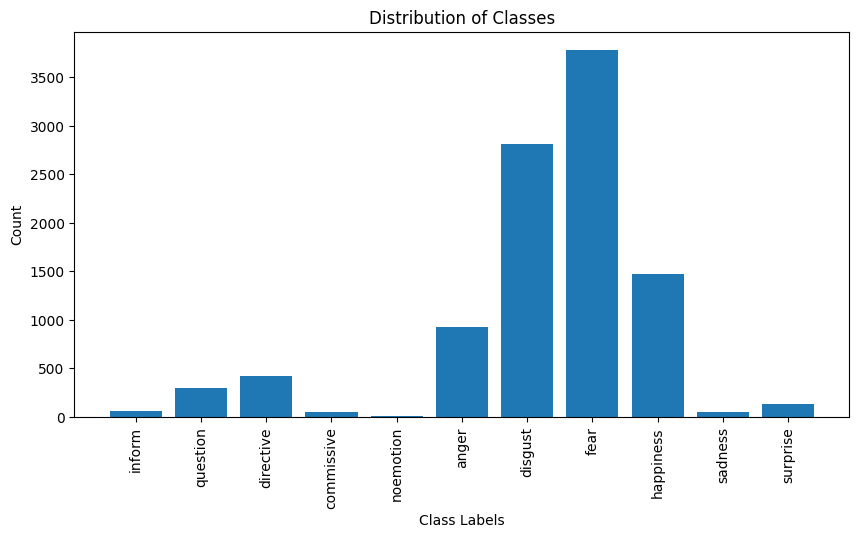

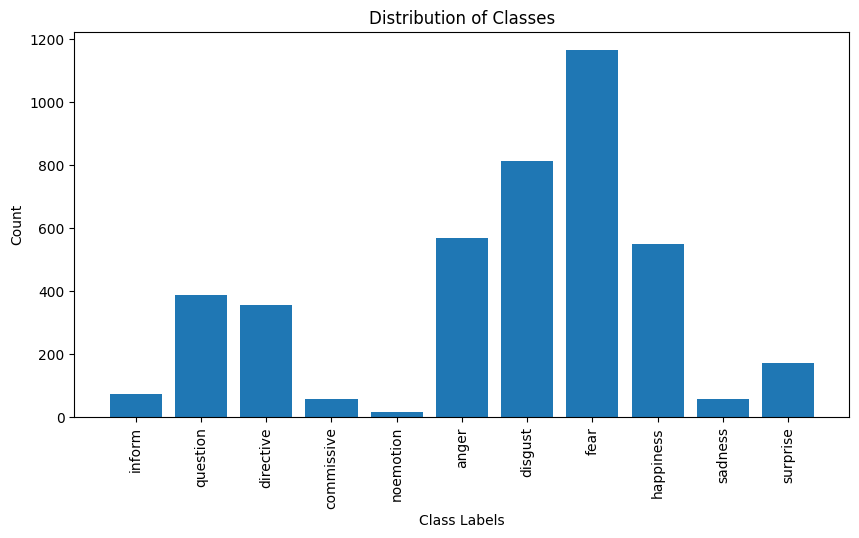

In [87]:
import matplotlib.pyplot as plt

# Assuming you have the class_counts as a dictionary with class labels as keys and counts as values

class_counts = df_train.iloc[:, -11:].sum()
class_counts_df = pd.DataFrame({'Class': class_counts.index, 'Count': class_counts.values})

# Plotting the first graph
plt.figure(figsize=(10, 5))
plt.bar(class_counts_df['Class'], class_counts_df['Count'])
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(rotation='vertical')
plt.show()

# Assuming you have the class_counts_2 as another dictionary with class labels as keys and counts as values

class_counts_2 = sampled_df.iloc[:, -11:].sum()
class_counts_2_df = pd.DataFrame({'Class': class_counts_2.index, 'Count': class_counts_2.values})
# Plotting the second graph
plt.figure(figsize=(10, 5))
plt.bar(class_counts_2_df['Class'], class_counts_2_df['Count'])
plt.xlabel('Class Labels')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(rotation='vertical')
plt.show()


In [88]:
X = df_train.iloc[0:, :-12]  # Text columns
y = df_train.iloc[:, -11:]  # Class labels

oversampler = RandomOverSampler(random_state=42)
print(X.columns)
print(y.columns)

# Oversample each class individually
oversampled_features = []
oversampled_labels = []
ros = RandomOverSampler(random_state=42)

for column in y.columns:
    print(column)
    class_data = y[column]
    X_resampled, y_resampled = ros.fit_resample(X, class_data)
    oversampled_features.append(X_resampled)
    oversampled_labels.append(y_resampled)

# Concatenate the oversampled data
oversampled_features_df = pd.concat(oversampled_features, axis=1)
oversampled_labels_df = pd.concat(oversampled_labels, axis=1)
oversampled_df = pd.concat([oversampled_features_df, oversampled_labels_df], axis=1)

Index(['texts'], dtype='object')
Index(['inform', 'question', 'directive', 'commissive', 'noemotion', 'anger',
       'disgust', 'fear', 'happiness', 'sadness', 'surprise'],
      dtype='object')
inform
question
directive
commissive
noemotion
anger
disgust
fear
happiness
sadness
surprise


In [89]:
import pandas as pd
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# Separate the features (text columns) and the target variable (class labels)
X = df_train.iloc[:, :-11]  # Text columns
y = df_train.iloc[:, -11:]  # Class labels

# Oversample each class individually
oversampled_features = []
oversampled_labels = []
ros = RandomOverSampler(random_state=42)

for column in y.columns:
    class_data = y[column]
    X_resampled, y_resampled = ros.fit_resample(X, class_data)
    #print(y_resampled)
    oversampled_features.append(X_resampled)
    oversampled_labels.append(np.round(y_resampled).astype(int))
    
    #print(oversampled_labels)

# Concatenate the oversampled data
oversampled_features_df = pd.concat(oversampled_features, axis=0)  # Concatenate along the row axis
oversampled_labels_df = pd.concat(oversampled_labels, axis=1)
oversampled_labels_df = oversampled_labels_df.fillna(0)
oversampled_labels_df = oversampled_labels_df.round().astype(int)
print(oversampled_labels_df)
oversampled_df = pd.concat([oversampled_features_df, oversampled_labels_df], axis=1)

# Print the columns of the oversampled DataFrame
print(oversampled_df)


      inform  question  directive  commissive  noemotion  anger  disgust   
0          0         0          1           0          0      0        0  \
1          0         1          0           0          0      0        0   
2          0         0          0           0          0      0        0   
3          0         0          0           0          0      0        0   
4          0         0          0           0          0      0        0   
...      ...       ...        ...         ...        ...    ...      ...   
9973       0         0          0           0          1      0        0   
9974       0         0          0           0          1      0        0   
9975       0         0          0           0          1      0        0   
9976       0         0          0           0          1      0        0   
9977       0         0          0           0          1      0        0   

      fear  happiness  sadness  surprise  
0        1          0        0         0  
1

In [90]:
print(oversampled_df.columns)
class_counts = oversampled_df.iloc[:, -11:].sum(numeric_only=True)
print(class_counts)

Index(['texts', 'category', 'inform', 'question', 'directive', 'commissive',
       'noemotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness',
       'surprise'],
      dtype='object')
inform        41861
question      42251
directive     42135
commissive    41775
noemotion     41469
anger         40623
disgust       30899
fear          41558
happiness     37361
sadness       41796
surprise      42086
dtype: int64


In [91]:
pip install git+https://github.com/phiyodr/multilabel-oversampling

  Cloning https://github.com/phiyodr/multilabel-oversampling to c:\users\rog\appdata\local\temp\pip-req-build-4eo7fvqm
  Resolved https://github.com/phiyodr/multilabel-oversampling to commit 0d11c5bb6c2eb83d4707fa7abc0c13b2f8d034c6
Note: you may need to restart the kernel to use updated packages.


  Running command git clone -q https://github.com/phiyodr/multilabel-oversampling 'C:\Users\ROG\AppData\Local\Temp\pip-req-build-4eo7fvqm'
    ERROR: Command errored out with exit status 1:
     command: 'c:\Users\ROG\Downloads\FP_DL\venv\Scripts\python.exe' -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\ROG\\AppData\\Local\\Temp\\pip-req-build-4eo7fvqm\\setup.py'"'"'; __file__='"'"'C:\\Users\\ROG\\AppData\\Local\\Temp\\pip-req-build-4eo7fvqm\\setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base 'C:\Users\ROG\AppData\Local\Temp\pip-pip-egg-info-bo0gi4l7'
         cwd: C:\Users\ROG\AppData\Local\Temp\pip-req-build-4eo7fvqm\
    Complete output (9 lines):
    Traceback (most recent call last):
      File "<string>", line 1,

### UNDERSAMPLING

In [121]:
sampled_df[:20]

texts             category   
491              i ll never ever work together with him      [inform, anger]  \
493   will you take my materials back from him for m...   [directive, anger]   
495                         oh my god i ve been cheated      [inform, anger]   
497   it s a brick i can not believe how stupid i wa...      [inform, anger]   
499   there was a guy on the sidewalk he had three n...      [inform, anger]   
554                   it smells like an ashtray in here      [inform, anger]   
556   what s wrong ? i thought we agreed that you we...      [inform, anger]   
558   look there are other ways to quit you can try ...      [inform, anger]   
560                               fine i want a divorce      [inform, anger]   
568          isn not there anything that sounds fishy ?    [question, anger]   
1217  yeah my head hurts that s all i ve been in phy...      [inform, anger]   
1363  what ? she was cheating on me with that ugly g...      [inform, anger]   
1365                                 but she lied to me      [inform, anger]   
1481  for god s sake it s too bloody how can people ...      [inform, anger]   
1483  you can not prick the fish to please the sick ...      [inform, anger]   
1485  just an animal ? but it has life too if you wa...    [question, anger]   
1810       with everything with everybody with all this      [inform, anger]   
1921  the tapping of your pen on your desk it s driv...      [inform, anger]   
1922  fine by the way would you mind not slurping yo...  [commissive, anger]   
1923  i don t slurp my coffee and plus how can you h...    [question, anger]   

      inform  question  directive  commissive  noemotion  anger  disgust   
491        1         0          0           0          0      0        1  \
493        1         0          1           0          0      0        0   
495        1         0          0           0          0      0        1   
497        1         0          0           0          0      0        1   
499        1         0          0           0          0      0        1   
554        1         0          0           0          0      0        1   
556        1         0          0           0          0      0        1   
558        1         0          0           0          0      0        1   
560        1         0          0           0          0      0        1   
568        1         0          0           0          0      0        0   
1217       1         0          0           0          0      0        1   
1363       1         0          0           0          0      0        1   
1365       1         0          0           0          0      0        1   
1481       1         0          0           0          0      0        1   
1483       1         0          0           0          0      0        1   
1485       1         0          0           0          0      0        0   
1810       1         0          0           0          0      0        1   
1921       1         0          0           0          0      0        1   
1922       1         1          0           0          0      0        0   
1923       1         0          0           0          0      0        0   

      fear  happiness  sadness  surprise  
491      0          0        0         0  
493      0          0        0         0  
495      0          0        0         0  
497      0          0        0         0  
499      0          0        0         0  
554      0          0        0         0  
556      0          0        0         0  
558      0          0        0         0  
560      0          0        0         0  
568      0          1        0         0  
1217     0          0        0         0  
1363     0          0        0         0  
1365     0          0        0         0  
1481     0          0        0         0  
1483     0          0        0         0  
1485     0          1        0         0  
1810     0          0        0         0 

In [122]:
sampled_df = sampled_df.reset_index(drop=True)

In [113]:
len(sampled_df)

2101

In [114]:

y_undersampled = mlb.fit_transform(sampled_df.category)

In [126]:
undersampled = []
n = 0
for i in range(len(sampled_df)):
    #print(i)
    #print(sampled_df['texts'][i],y_undersampled[i])
    undersampled.append({'text':sampled_df['texts'][i],'label':y_undersampled[i]})
    

In [127]:
us_id, us_at, us_lb = [],[],[]
for i in undersampled:
    res = BERT_Tokenize(i)
    #print(res)
    us_id.append(res['input_ids'])
    us_at.append(res['attention_mask'])
    us_lb.append(res['label'])

In [128]:

us_id = np.array(us_id)
us_at = np.array(us_at)
us_lb = np.array(us_lb)

In [129]:
# dataset = tf.data.Dataset.from_tensor_slices((us_id, us_at, us_lb))
input_ids2 = us_id
attention_mask2 = us_at
labels2 = us_lb
# # Shuffle and batch the dataset
# batch_size = 32
# dataset = dataset.shuffle(100).batch(batch_size)

# Define your model
model2 = create_bert_gru_model()
history2 = model2.fit([input_ids2, attention_mask2], labels2, verbose=1)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


66/66 [==============================] - 646s 9s/step - loss: 0.3423 - accuracy: 0.8454 - precision: 0.6069 - recall: 0.4250


In [139]:
history2.history

{'loss': [0.3423428535461426],
 'accuracy': [0.8453983068466187],
 'precision': [0.6068637371063232],
 'recall': [0.425035685300827]}

In [141]:
i = 0
predictions = model2.predict([ts_id, ts_at])

binary_predictions = np.round(predictions)

multilabel_predictions = predictions > 0.5


i += 1


1/1 [==============================] - 5s 5s/step


In [142]:
binary_predictions

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]], dtype=float32)

In [143]:
sampled_df[10:15]

texts         category   
10  yeah my head hurts that s all i ve been in phy...  [inform, anger]  \
11  what ? she was cheating on me with that ugly g...  [inform, anger]   
12                                 but she lied to me  [inform, anger]   
13  for god s sake it s too bloody how can people ...  [inform, anger]   
14  you can not prick the fish to please the sick ...  [inform, anger]   

    inform  question  directive  commissive  noemotion  anger  disgust  fear   
10       1         0          0           0          0      0        1     0  \
11       1         0          0           0          0      0        1     0   
12       1         0          0           0          0      0        1     0   
13       1         0          0           0          0      0        1     0   
14       1         0          0           0          0      0        1     0   

    happiness  sadness  surprise  
10          0        0         0  
11          0        0         0  
12          0        0         0  
13          0        0         0  
14          0        0         0

### OVERSAMPLING

In [131]:
oversampled_df[:20]

texts   
0   say jim how about going for a few beers after ...  \
1   you know that is tempting but is really not go...   
2         what do you mean ? it will help us to relax   
3   do you really think so ? i don not it will jus...   
4   i guess you are right but what shall we do ? i...   
5   i suggest a walk over to the gym where we can ...   
6   that s a good idea i hear mary and sally often...   
7   sounds great to me if they are willing we coul...   
8                                   good let s go now   
9                                           all right   
10                              can you do push ups ?   
11  of course i can it s a piece of cake believe i...   
12                 really ? i think that s impossible   
13                             you mean 30 push ups ?   
14                                               yeah   
15  it s easy if you do exercise everyday you can ...   
16                  can you study with the radio on ?   
17                    no i listen to background music   
18                           what is the difference ?   
19                   the radio has too many comerials   

                   category  inform  question  directive  commissive   
0    [directive, noemotion]       0         0          1           0  \
1   [commissive, noemotion]       0         1          0           0   
2     [question, noemotion]       0         0          0           0   
3     [question, noemotion]       0         0          0           0   
4     [question, noemotion]       0         0          0           0   
5    [directive, noemotion]       0         0          1           0   
6   [commissive, happiness]       0         1          0           0   
7       [inform, happiness]       0         0          0           0   
8    [directive, happiness]       0         0          1           0   
9   [commissive, happiness]       0         1          0           0   
10    [question, noemotion]       0         0          0           0   
11      [inform, noemotion]       0         0          0           0   
12     [question, surprise]       0         0          0           0   
13    [question, noemotion]       0         0          0           0   
14      [inform, noemotion]       0         0          0           0   
15      [inform, noemotion]       0         0          0           0   
16    [question, noemotion]       0         0          0           0   
17      [inform, noemotion]       0         0          0           0   
18    [question, noemotion]       0         0          0           0   
19      [inform, noemotion]       0         0          0           0   

    noemotion  anger  disgust  fear  happiness  sadness  surprise  
0           0      0        0     1          0        0         0  
1           0      0        0     1          0        0         0  
2           0      0        0     1          1        0         0  
3           0      0        0     1          1        0         0  
4           0      0        0     1          1        0         0  
5           0      0        0     1          0        0         0  
6           0      1        0     0          0        0         0  
7           0      1        1     0          0        0         0  
8           0      1        0     0          0        0         0  
9           0      1        0     0          0        0         0  
10          0      0        0     1          1        0         0  
11          0      0        1     1          0        0         0  
12          0      0        0     0          1        0         1  
13          0      0        0     1          1        0         0  
14          0      0        1     1          0        0         0  
15          0      0        1     1          0        0         0  
16          0      0        0     1          1        0         0  
17          0      0        1     1          0        0         0  
18          0      0        0     1          

In [132]:
oversampled_df = oversampled_df.reset_index(drop=True)

In [133]:
len(oversampled_df)

96348

In [134]:

y_oversampled = mlb.fit_transform(oversampled_df.category)

In [135]:
oversampled = []
n = 0
for i in range(len(sampled_df)):
    #print(i)
    #print(sampled_df['texts'][i],y_oversampled[i])
    oversampled.append({'text':sampled_df['texts'][i],'label':y_oversampled[i]})
    

In [136]:
os_id, os_at, os_lb = [],[],[]
for i in undersampled:
    res = BERT_Tokenize(i)
    #print(res)
    os_id.append(res['input_ids'])
    os_at.append(res['attention_mask'])
    os_lb.append(res['label'])

In [137]:

os_id = np.array(os_id)
os_at = np.array(os_at)
os_lb = np.array(os_lb)

In [138]:
# dataset = tf.data.Dataset.from_tensor_slices((os_id, os_at, os_lb))
input_ids3 = os_id
attention_mask3 = os_at
labels3 = os_lb
# # Shuffle and batch the dataset
# batch_size = 32
# dataset = dataset.shuffle(100).batch(batch_size)

# Define your model
model3 = create_bert_gru_model()
history3 = model3.fit([input_ids3, attention_mask3], labels3, verbose=1)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


66/66 [==============================] - 591s 9s/step - loss: 0.3240 - accuracy: 0.8551 - precision: 0.6491 - recall: 0.4419


In [140]:
history3.history

{'loss': [0.3239806294441223],
 'accuracy': [0.8550906777381897],
 'precision': [0.6490737795829773],
 'recall': [0.44193241000175476]}

In [144]:
i = 0
predictions = model3.predict([ts_id, ts_at])

binary_predictions = np.round(predictions)

multilabel_predictions = predictions > 0.5


i += 1


1/1 [==============================] - 7s 7s/step


In [145]:
binary_predictions

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]], dtype=float32)

In [146]:
oversampled_df[10:15]

texts               category   
10                              can you do push ups ?  [question, noemotion]  \
11  of course i can it s a piece of cake believe i...    [inform, noemotion]   
12                 really ? i think that s impossible   [question, surprise]   
13                             you mean 30 push ups ?  [question, noemotion]   
14                                               yeah    [inform, noemotion]   

    inform  question  directive  commissive  noemotion  anger  disgust  fear   
10       0         0          0           0          0      0        0     1  \
11       0         0          0           0          0      0        1     1   
12       0         0          0           0          0      0        0     0   
13       0         0          0           0          0      0        0     1   
14       0         0          0           0          0      0        1     1   

    happiness  sadness  surprise  
10          1        0         0  
11          0        0         0  
12          1        0         1  
13          1        0         0  
14          0        0         0